# Student Performance Prediction

## Objective
As one might expect from the title of the notebook, our objective here is to predict student performance given some data on the students.

## Packages

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import chi2
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import confusion_matrix, classification_report

# Seaborn settings
sns.set()
palette='Set1'
sns.set_palette(palette=palette)
palette = sns.color_palette(palette=palette)

## Preprocessing
As a first step, the data about the students needs to be encoded in a way that is more usable by computers. Most of the data is already binary, and for those columns that are not we'll choose a strategy to binarize them... For now... This simplification could prove to be a bad idea, but let's try it out.

Let's rename the columns so that they are easier to use, and make a copy of the original dataframe in case we need it.

In [2]:
df = pd.read_csv("/Users/jacobder/Documents/data/StudentsPerformance.csv")
df = df.rename(
        columns={
            'race/ethnicity': 'race',
            'parental level of education': 'parent_education',
            'test preparation course': 'test_prep',
            'math score': 'math',
            'reading score': 'reading',
            'writing score': 'writing'
        }
    )

df_copy = df.copy()
df.head()

,gender,race,parent_education,lunch,test_prep,math,reading,writing
0,female,group B,bachelor's degree,standard,none,72,72,74
1,female,group C,some college,standard,completed,69,90,88
2,female,group B,master's degree,standard,none,90,95,93
3,male,group A,associate's degree,free/reduced,none,47,57,44
4,male,group C,some college,standard,none,76,78,75


### Encoding Gender
This is binary (the data, not identification), so we'll just assign labels **1** to females and **0** to males. 

In [3]:
def gender_label(gender):
    if gender == 'female':
        return 1
    else:
        return 0
    
    
df['gender'] = df['gender'].apply(gender_label)

df.head()

,gender,race,parent_education,lunch,test_prep,math,reading,writing
0,1,group B,bachelor's degree,standard,none,72,72,74
1,1,group C,some college,standard,completed,69,90,88
2,1,group B,master's degree,standard,none,90,95,93
3,0,group A,associate's degree,free/reduced,none,47,57,44
4,0,group C,some college,standard,none,76,78,75


### Encoding Parental Education Level
To binarize this data, we'll choose a threshold on minimum education. For our purposes, we'll assign label **1** to parents who got any sort of degree from a college and label **0** to people who did not.

In [4]:
def parent_education(edu):
    educations = ["associate's degree", "bachelor's degree", "master's degree"]
    if edu in educations:
        return 1
    else:
        return 0
    

df['parent_education'] = df['parent_education'].apply(parent_education)

df.head()

,gender,race,parent_education,lunch,test_prep,math,reading,writing
0,1,group B,1,standard,none,72,72,74
1,1,group C,0,standard,completed,69,90,88
2,1,group B,1,standard,none,90,95,93
3,0,group A,1,free/reduced,none,47,57,44
4,0,group C,0,standard,none,76,78,75


### Encoding Lunch Type
This data is binary, so we'll assign label **1** to standard lunch types and label **0** to free/reduced lunch types.

In [5]:
def lunch_type(lunch_type):
    if lunch_type == 'standard':
        return 1
    else:
        return 0
    

df['lunch'] = df['lunch'].apply(lunch_type)

df.head()

,gender,race,parent_education,lunch,test_prep,math,reading,writing
0,1,group B,1,1,none,72,72,74
1,1,group C,0,1,completed,69,90,88
2,1,group B,1,1,none,90,95,93
3,0,group A,1,0,none,47,57,44
4,0,group C,0,1,none,76,78,75


### Encoding Test Preparation Course Completion
Binary again. We assign **1** to students who completed courses and **0** to student who did not.

In [6]:
def test_prep(completion):
    if completion == 'completed':
        return 1
    else:
        return 0
    
    
df['test_prep'] = df['test_prep'].apply(test_prep)

df.head()

,gender,race,parent_education,lunch,test_prep,math,reading,writing
0,1,group B,1,1,0,72,72,74
1,1,group C,0,1,1,69,90,88
2,1,group B,1,1,0,90,95,93
3,0,group A,1,0,0,47,57,44
4,0,group C,0,1,0,76,78,75


### Encoding Exam Scores
The exam score data is actually integer-valued, ranging 1-100. This means that if we keep the exam score data as it is currently, the task of predicting student performance is a regression problem. However, performing regression on students to predict their *exact* performance on exams doesn't exactly help anyone. What is more helpful is simply trying to predict whether students will pass the exams or not—changing the task from one of regression to one of classification provides better opportunities for outreach to students at risk of not passing the exams, and it is an easier task to work on since we have limited data on the students in the first place.

Accordingly, we choose thresholds for passing the exams. Students who score at or above the threshold pass, and students who score below do not. However, choosing thresholds is a small task in itself. We ought to put at least a little thought into the thresholds rather than just picking a random value—testing is difficult for students, and they deserve the fairest judgement possible.

Let's take a look at the various kernel density estimations of scores as well as as some statistics for measuring central tendency.

Math stats — Mean: 66.1, Median: 66.0, Mode: 65.0 

Reading stats — Mean: 69.2, Median: 70.0, Mode: 72.0 

Writing stats — Mean: 68.1, Median: 69.0, Mode: 74.0 



<AxesSubplot:ylabel='Density'>

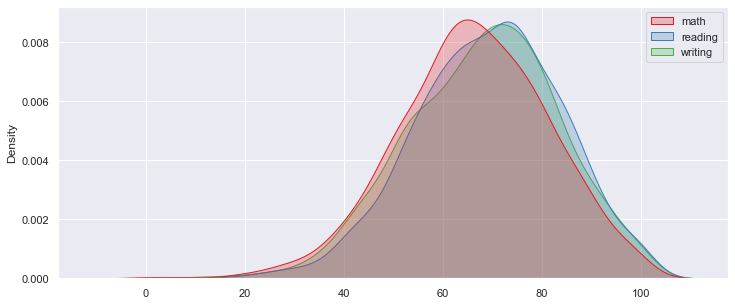

In [7]:
plt.figure(figsize=(12,5))
print('Math stats — Mean: %.1f, Median: %.1f, Mode: %.1f' % 
      (df['math'].mean(), df['math'].median(), df['math'].mode()), '\n')

print('Reading stats — Mean: %.1f, Median: %.1f, Mode: %.1f' % 
      (df['reading'].mean(), df['reading'].median(), df['reading'].mode()), '\n')

print('Writing stats — Mean: %.1f, Median: %.1f, Mode: %.1f' % 
      (df['writing'].mean(), df['writing'].median(), df['writing'].mode()), '\n')

sns.kdeplot(data=df[['math', 'reading', 'writing']], fill=True)

Thes KDEs are pretty symmetric, so setting the thresholds equal to the floor of the means should be fine.

In [8]:
def math_pass(score):
    if score >= 66:
        return 1
    else:
        return 0
    

def reading_pass(score):
    if score >= 69:
        return 1
    else:
        return 0
    

def writing_pass(score):
    if score >= 68:
        return 1
    else:
        return 0
        

df['math'] = df['math'].apply(math_pass)
df['reading'] = df['reading'].apply(reading_pass)
df['writing'] = df['writing'].apply(writing_pass)


df.head()

,gender,race,parent_education,lunch,test_prep,math,reading,writing
0,1,group B,1,1,0,1,1,1
1,1,group C,0,1,1,1,1,1
2,1,group B,1,1,0,1,1,1
3,0,group A,1,0,0,0,0,0
4,0,group C,0,1,0,1,1,1


### Encoding Race
The race data for the students cannot be binarized by setting some sort of threshold like before. Instead we will just one-hot encode this data.

Simultaneously we're going to start prepping the data for modeling. This means we'll end up with a dataset **X**
consisting of all encoded features of the students, and some target vectors **y_math**, **y_reading**,and **y_writing** each consisting of a single column of their respective exam data.

In [9]:
features = ['gender', 'race', 'parent_education', 'lunch', 'test_prep']
X = pd.get_dummies(df[features], columns=['race'])
y_math = df['math']
y_reading = df['reading']
y_writing = df['writing']
                      
X.head()

,gender,parent_education,lunch,test_prep,race_group A,race_group B,race_group C,race_group D,race_group E
0,1,1,1,0,0,1,0,0,0
1,1,0,1,1,0,0,1,0,0
2,1,1,1,0,0,1,0,0,0
3,0,1,0,0,1,0,0,0,0
4,0,0,1,0,0,0,1,0,0


## Feature Selection
Now that the data is in a usable condition, our next step is to examine which variables are worth using in our model. To this end, note that both the variables and target outputs are categorical variables, hence we will use a chi-squared test to determine which variables to use.

There is a class called SelectKBest in Scikit-learn that automatically selects the K features which score the highest on the chi-squared test, but we'll do it manually here since it's not that difficult.

### Chi-squared Testing

#### Math Scores Testing

In [10]:
def top_features(k, X, y):
    # Compute chi-squared values.
    chi2_scores = chi2(X, y)[0]
    # Get the indices of the top four scores.
    cols = np.argpartition(chi2_scores, kth=-k)[-k:]
    # Ordering by chi-squared score.
    cols = cols[np.argsort(chi2_scores[cols])]
    
    return (cols, chi2_scores)

    
math_cols, chi2_scores = top_features(4, X=X, y=y_math)
for index in math_cols:
    print(f'{X.columns[index]} score: {chi2_scores[index]:.3f}')

gender score: 9.366
test_prep score: 12.866
lunch score: 26.665
race_group E score: 26.819


#### Reading Scores Testing

In [11]:
reading_cols, chi2_scores = top_features(4, X=X, y=y_reading)
for index in reading_cols:
    print(f'{X.columns[index]} score: {chi2_scores[index]:.3f}')

race_group A score: 8.827
lunch score: 14.597
gender score: 22.169
test_prep score: 27.994


#### Writing Scores Testing

In [12]:
writing_cols, chi2_scores = top_features(4, X=X, y=y_writing)
for index in writing_cols:
    print(f'{X.columns[index]} score: {chi2_scores[index]:.3f}')

race_group A score: 12.070
lunch score: 17.395
gender score: 32.592
test_prep score: 48.449


### Visualizations
Now to dig a little deeper with some visualizations, so that after modeling it's clear how the selected features factor into the predictions. For brevity, only the top two features will be visualized, but the remaining features can be visualized in similar ways.

#### Race Visualization
For the race visualization, we'll use a version of a box plot to compare each group. Note that the data for this plot is coming df_copy, the dataset *prior* to encoding the exam scores—this allows for distributions to be visualized in a meaningful way.

<AxesSubplot:xlabel='race', ylabel='math'>

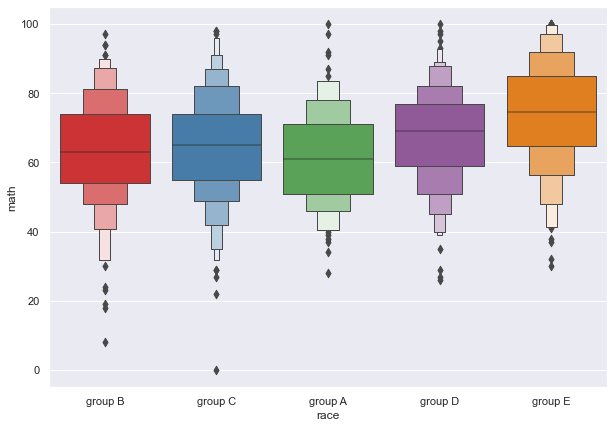

In [13]:
plt.figure(figsize=(10,7))
sns.boxenplot(data=df_copy, x='race', y='math', )

What we deduce immediately from this graphic is that every quantile of the distribution for group E scored higher than the corresponding quantiles of the other groups. Thus it makes sense we would observe more exam passes in group E, leading to the high score on the chi-squared test.

#### Lunch Type Visualization
To get an idea of why lunch type scored quite high on the chi-squared test we'll take a look at two KDEs side by side.

<AxesSubplot:ylabel='math'>

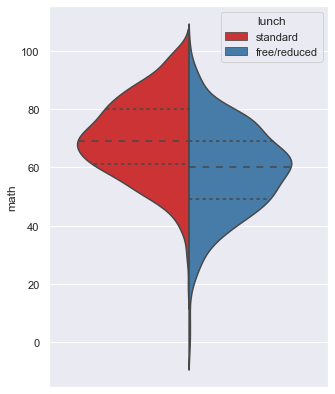

In [14]:
plt.figure(figsize=(5,7))
sns.violinplot(data=df_copy, y='math', x=[""]*len(df_copy), hue='lunch', split=True, inner='quartile')

Again, it's clear that the shape of the distribution of scores for students with standard lunch is essentially the same as that for the students with a free/reduced lunch, just shifted to the right. In short, students with standard lunches tended to score higher on the math exams.

#### Reading Visualization
Since the features that scored the highest on the chi-squared test for reading were binary, we'll just visualize both at the same time, and use the same KDE comparison method as above.

<AxesSubplot:xlabel='gender', ylabel='reading'>

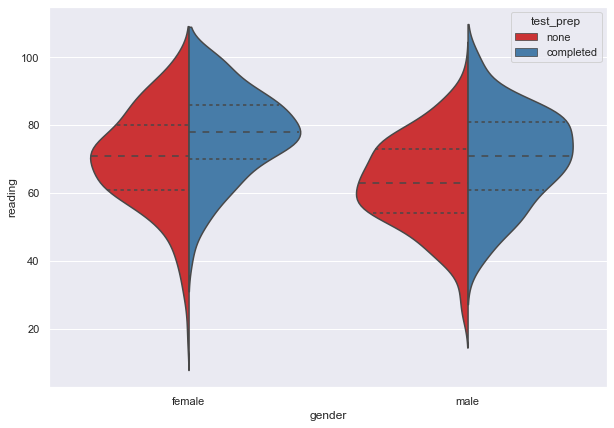

In [15]:
plt.figure(figsize=(10,7))
sns.violinplot(data=df_copy, x='gender', y='reading', hue='test_prep', split=True, inner='quartile')

There are two things to notice here. First note that students who completed a test preparation course had a tendency for higher exam scores, regardless of gender. Second, if we examine the quartile lines closely we see that females tended to score higher than males, regardless of test preparation.

#### Writing Visualization
The results of the chi-squared test for writing were the same as those for reading, so the same visualization will be used.

<AxesSubplot:xlabel='gender', ylabel='writing'>

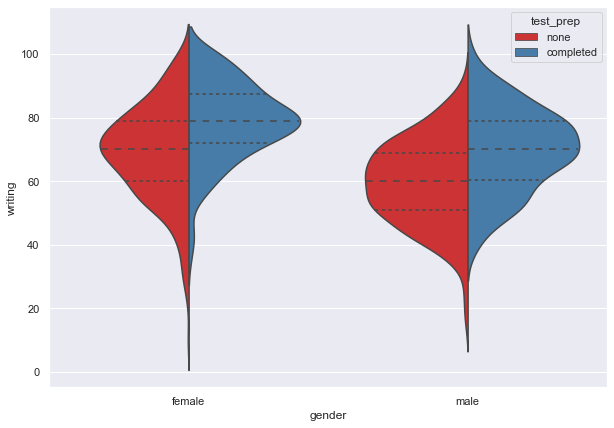

In [16]:
plt.figure(figsize=(10,7))
sns.violinplot(data=df_copy, x='gender', y='writing', hue='test_prep', split=True, inner='quartile')

The observations for this visualization are the same as the previous observations for reading.

## Modeling
Great! After visualizing some of the more influential variables, according to the chi-squared tests, it's finally time to pick a model and make some predictions.

I'm choosing to use a random forest classifier, but other tree methods should work as well.

In [17]:
def predict_student_performance(data, target, features):
    # Use only selected features from chi-squared testing.
    X_reduced = data.iloc[:,features]

    X_train, X_test, y_train, y_test = train_test_split(X_reduced, target)
    
    param_grid = {
        'n_estimators': [50, 100, 150],
        'max_depth': [5, 10, 15]
    }

    rf_grid = GridSearchCV(RandomForestClassifier(), param_grid=param_grid, n_jobs=-1)
    rf_grid.fit(X_train, y_train)

    y_pred = rf_grid.predict(X_test)
    
    print('Best parameters:', rf_grid.best_params_, '\n')
    print('Confusion Matrix: ', '\n', confusion_matrix(y_test, y_pred), '\n')
    print('Classification Report: ', '\n', classification_report(y_test, y_pred, zero_division=0), '\n')
    

print('================ Math Predictions =================')
predict_student_performance(data=X, target=y_math, features=math_cols)

print('=============== Reading Predictions ================')
predict_student_performance(data=X, target=y_reading, features=reading_cols)

print('=============== Writing Predictions ================')
predict_student_performance(data=X, target=y_writing, features=writing_cols)

================ Math Predictions =================
Best parameters: {'max_depth': 5, 'n_estimators': 100} 

Confusion Matrix:  
 [[79 41]
 [45 85]] 

Classification Report:  
               precision    recall  f1-score   support

           0       0.64      0.66      0.65       120
           1       0.67      0.65      0.66       130

    accuracy                           0.66       250
   macro avg       0.66      0.66      0.66       250
weighted avg       0.66      0.66      0.66       250
 

=============== Reading Predictions ================
Best parameters: {'max_depth': 5, 'n_estimators': 100} 

Confusion Matrix:  
 [[81 28]
 [54 87]] 

Classification Report:  
               precision    recall  f1-score   support

           0       0.60      0.74      0.66       109
           1       0.76      0.62      0.68       141

    accuracy                           0.67       250
   macro avg       0.68      0.68      0.67       250
weighted avg       0.69      0.67      0.67 

## Conclusions
So, it looks like the predictions for scores on the writing exam were the most successful, followed by reading and math. I suppose this makes some degree of sense, given that the chi-squared test produced the highest values when writing was the target output.

In this notebook the most striking pieces of information actually came from feature selection, with modeling coming almost as an afterthought. In particular, it's quite interesting to see that the most influential features for math exams scores were lunch type and belonging to race group E, while the most influential for reading and writing were test preparation and gender. This information alone is sufficient for outreach to students at risk of not passing some exam(s), depending on the context of an analysis like this—extending free tutoring services to students from lower-income families, "marketing" subjects like reading and writing to male students, etc.

As for tuning the modeling process, there are a few possibilites. Namely, changing things like the thresholds for passing an exam or for parental education levels. Moreover, gradient boosting is an alternative, viable approach to a random forest, or even naive bayes if data is scarce.